# Hyperparameter Tuning (Supplementary Notebook)

This notebook explores a grid search with repeated k-fold cross validation scheme for tuning the hyperparameters of the LightGBM model used in forecasting the M5 dataset. In general, the techniques used below can be also be adapted for other forecasting models, whether they be classical statistical models or machine learning methods.

Prepared by: Sebastian C. Ibañez

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

plt.rcParams['figure.figsize'] = [15, 5]

np.set_printoptions(precision = 6, suppress = True)

### CREATE X,Y ####
def create_xy(series, window_size, prediction_horizon, shuffle = False):
    x = []
    y = []
    for i in range(0, len(series)):
        if len(series[(i + window_size):(i + window_size + prediction_horizon)]) < prediction_horizon:
            break
        x.append(series[i:(i + window_size)])
        y.append(series[(i + window_size):(i + window_size + prediction_horizon)])
    x = np.array(x)
    y = np.array(y)
    return x,y

date_list = [d.strftime('%Y-%m-%d') for d in pd.date_range(start = '2011-01-29', end = '2016-04-24')]

df_sales = pd.read_csv('../data/m5/sales_train_validation.csv')
df_sales.rename(columns = dict(zip(df_sales.columns[6:], date_list)), inplace = True)

df_sales_total_by_store = df_sales.groupby(['store_id']).sum()

series = df_sales_total_by_store.iloc[0]

### HYPERPARAMETERS ###
window_size = 365
prediction_horizon = 1

### TRAIN VAL SPLIT ### (include shuffling later)
test_size = 28
split_time = len(series) - test_size

train_series = series[:split_time]
test_series = series[split_time - window_size:]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

train_y = train_y.flatten()
test_y = test_y.flatten()

     Naive MAE: 698.0000
  s7-Naive MAE: 372.2857
 s30-Naive MAE: 330.8214
s365-Naive MAE: 247.9286
  LightGBM MAE: 208.9156


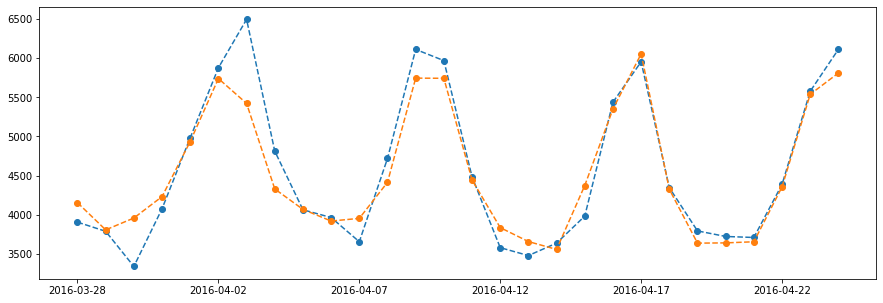

In [2]:
model = lgb.LGBMRegressor(first_metric_only = True)

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)],
          early_stopping_rounds = 10,
          verbose = 0)

forecast = model.predict(test_x)
s1_naive = series[-29:-1].to_numpy()
s7_naive = series[-35:-7].to_numpy()
s30_naive = series[-56:-28].to_numpy()
s365_naive = series[-364:-336].to_numpy()

print('     Naive MAE: %.4f' % (np.mean(np.abs(s1_naive - test_y))))
print('  s7-Naive MAE: %.4f' % (np.mean(np.abs(s7_naive - test_y))))
print(' s30-Naive MAE: %.4f' % (np.mean(np.abs(s30_naive - test_y))))
print('s365-Naive MAE: %.4f' % (np.mean(np.abs(s365_naive - test_y))))
print('  LightGBM MAE: %.4f' % (np.mean(np.abs(forecast - test_y))))

series[-test_size:].plot(marker = 'o', linestyle = '--')
plt.plot(forecast, marker = 'o', linestyle = '--')
plt.show()

###  Hyperparameter Tuning

#### Number of Trees

In [3]:
trees = [10, 50, 100, 500, 1000, 2000]

results = []
names = []
for i in trees:
    
    params = {
        'n_estimators': i,
    }
    
    cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
    scores = cross_val_score(lgb.LGBMRegressor(**params), train_x, train_y, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
    results.append(scores)
    names.append(i)
    print('%3d --- MAE: %.3f (%.3f)' % (i, np.mean(scores), np.std(scores)))

plt.boxplot(results, labels = names, showmeans = True)
plt.show()

 10 --- MAE: -385.639 (31.537)


 50 --- MAE: -283.540 (21.324)


#### Tree Depth

  1 --- MAE: -292.235 (24.008)
  2 --- MAE: -284.534 (20.113)
  3 --- MAE: -278.984 (20.519)
  4 --- MAE: -276.622 (21.169)
  5 --- MAE: -280.497 (21.999)
  6 --- MAE: -283.877 (21.382)
  7 --- MAE: -284.667 (21.436)
  8 --- MAE: -288.216 (21.230)
  9 --- MAE: -287.373 (21.043)
 10 --- MAE: -288.503 (20.929)


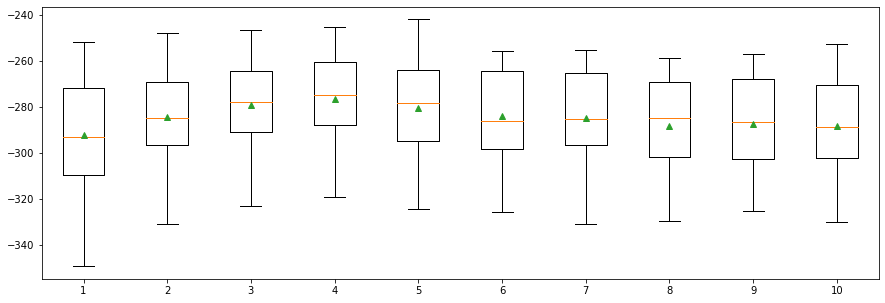

In [4]:
results = []
names = []
for i in range(1, 11):
    
    params = {
        'max_depth': i,
        'num_leaves': 2**i,
    }
    
    cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
    scores = cross_val_score(lgb.LGBMRegressor(**params), train_x, train_y, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
    results.append(scores)
    names.append(i)
    print('%3d --- MAE: %.3f (%.3f)' % (i, np.mean(scores), np.std(scores)))

plt.boxplot(results, labels = names, showmeans = True)
plt.show()

#### Learning Rate

0.000 --- MAE: -748.947 (39.458)
0.001 --- MAE: -695.973 (38.578)
0.010 --- MAE: -391.718 (30.680)
0.100 --- MAE: -285.091 (21.551)
1.000 --- MAE: -437.648 (23.715)


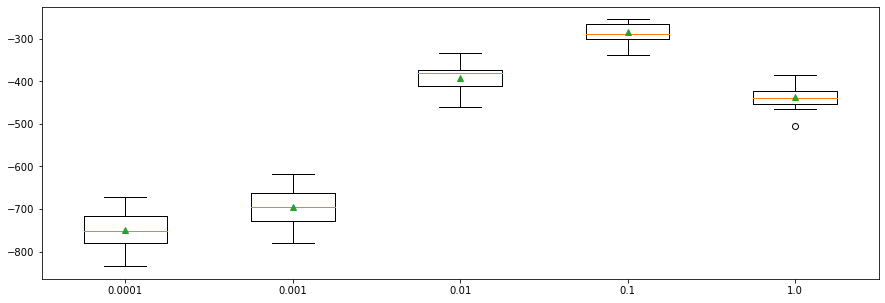

In [5]:
rates = [0.0001, 0.001, 0.01, 0.1, 1.0]

results = []
names = []
for i in rates:
    
    params = {
        'learning_rate': i,
    }
    
    cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
    scores = cross_val_score(lgb.LGBMRegressor(**params), train_x, train_y, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
    results.append(scores)
    names.append(i)
    print('%.3f --- MAE: %.3f (%.3f)' % (i, np.mean(scores), np.std(scores)))

plt.boxplot(results, labels = names, showmeans = True)
plt.show()

#### Boosting Type

- `gbdt`: Gradient Boosting Decision Tree (GDBT).
- `dart`: Dropouts meet Multiple Additive Regression Trees (DART).
- `goss`: Gradient-based One-Side Sampling (GOSS).

gbdt --- MAE: -285.091 (21.551)
dart --- MAE: -481.225 (33.006)
goss --- MAE: -291.263 (21.742)


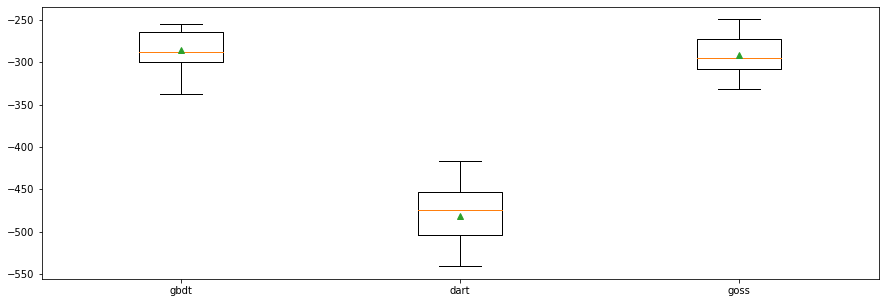

In [6]:
types = ['gbdt', 'dart', 'goss']

results = []
names = []
for i in types:
    
    params = {
        'boosting_type': i,
    }
    
    cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
    scores = cross_val_score(lgb.LGBMRegressor(**params), train_x, train_y, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
    results.append(scores)
    names.append(i)
    print('%s --- MAE: %.3f (%.3f)' % (i, np.mean(scores), np.std(scores)))

plt.boxplot(results, labels = names, showmeans = True)
plt.show()

#### More than one variable...

In [9]:
types = ['gbdt', 'dart', 'goss']

results = []
for i in types:
    
    for j in range(1, 11):
    
        params = {
            'n_estimators': 2000,
            'learning_rate': 0.1,
            'max_depth': j,
            'num_leaves': 2**j,
            'boosting_type': i,
        }

        cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
        scores = cross_val_score(lgb.LGBMRegressor(**params), train_x, train_y, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
        results.append(scores)

        print('%s %d --- MAE: %.3f (%.3f)' % (i, j, np.mean(scores), np.std(scores)))

gbdt 1 --- MAE: -287.860 (21.319)
gbdt 2 --- MAE: -298.625 (20.007)
gbdt 3 --- MAE: -288.742 (21.788)
gbdt 4 --- MAE: -284.235 (20.843)
gbdt 5 --- MAE: -285.302 (21.250)
gbdt 6 --- MAE: -288.334 (21.073)
gbdt 7 --- MAE: -288.306 (21.382)
gbdt 8 --- MAE: -290.893 (21.207)


/opt/conda/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


gbdt 9 --- MAE: -291.163 (22.049)
gbdt 10 --- MAE: -291.799 (21.347)
dart 1 --- MAE: -277.039 (21.229)
dart 2 --- MAE: -278.634 (19.236)
dart 3 --- MAE: -274.650 (21.226)
dart 4 --- MAE: -274.975 (22.260)
dart 5 --- MAE: -276.816 (22.355)
dart 6 --- MAE: -278.424 (22.700)
dart 7 --- MAE: -280.250 (22.238)
dart 8 --- MAE: -281.548 (23.202)
dart 9 --- MAE: -282.776 (23.881)
dart 10 --- MAE: -283.613 (23.785)
goss 1 --- MAE: -301.392 (22.057)
goss 2 --- MAE: -305.135 (17.874)
goss 3 --- MAE: -297.664 (18.621)
goss 4 --- MAE: -297.698 (19.858)
goss 5 --- MAE: -296.022 (18.470)
goss 6 --- MAE: -295.540 (20.386)
goss 7 --- MAE: -290.380 (19.665)
goss 8 --- MAE: -295.496 (20.014)
goss 9 --- MAE: -292.827 (20.048)
goss 10 --- MAE: -293.961 (22.087)


### Final Model

     Naive MAE: 698.0000
  s7-Naive MAE: 372.2857
 s30-Naive MAE: 330.8214
s365-Naive MAE: 247.9286
  LightGBM MAE: 200.5037


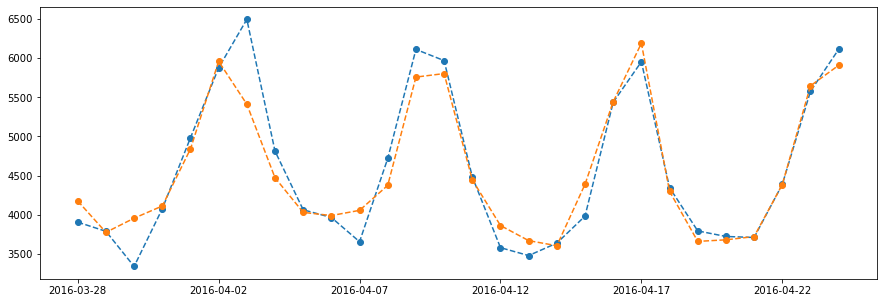

In [16]:
params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart'
}

model = lgb.LGBMRegressor(first_metric_only = True, **params)

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)],
          #early_stopping_rounds = 10,
          verbose = 0)

forecast = model.predict(test_x)
s1_naive = series[-29:-1].to_numpy()
s7_naive = series[-35:-7].to_numpy()
s30_naive = series[-56:-28].to_numpy()
s365_naive = series[-364:-336].to_numpy()

print('     Naive MAE: %.4f' % (np.mean(np.abs(s1_naive - test_y))))
print('  s7-Naive MAE: %.4f' % (np.mean(np.abs(s7_naive - test_y))))
print(' s30-Naive MAE: %.4f' % (np.mean(np.abs(s30_naive - test_y))))
print('s365-Naive MAE: %.4f' % (np.mean(np.abs(s365_naive - test_y))))
print('  LightGBM MAE: %.4f' % (np.mean(np.abs(forecast - test_y))))

series[-test_size:].plot(marker = 'o', linestyle = '--')
plt.plot(forecast, marker = 'o', linestyle = '--')
plt.show()